## Imports

In [1]:
#import the Forward Modelling Engine modules - LoopStructural
from LoopStructural import GeologicalModel
from LoopStructural.datasets import load_noddy_single_fold
from LoopStructural.visualisation.model_visualisation import LavaVuModelViewer
from LoopStructural.utils.helper import strike_dip_vector, plunge_and_plunge_dir_to_vector
# from LoopStructural.visualisation.rotation_angle_plotter import RotationAnglePlotter
# import other libraries
import pandas as pd
import numpy as np
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
import logging
# logging.getLogger().setLevel(logging.INFO)

/home/lgrose/miniconda3/envs/loop/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
Cannot import Surfe


In [2]:
# load the sample data
data, boundary_points = load_noddy_single_fold()
data.head()
# boundary_points[0,:] = 0
# boundary_points[1,:] = 10000

,X,Y,Z,dip,strike,type,coord,random
972,500.0,500.0,5500.0,69.965373,399.166448,s0,NaN,0.126657
976,500.0,500.0,6000.0,69.965373,399.166448,s0,NaN,0.376144
980,500.0,500.0,6500.0,69.965373,399.166448,s0,NaN,0.731684
984,500.0,500.0,7000.0,69.965373,399.166448,s0,NaN,0.479522
988,500.0,500.0,7500.0,69.965373,399.166448,s0,NaN,0.465607


The input dataset was generated using Noddy by sampling the orientation of a structure on a regular grid. We have loaded it into a pandas DataFrame, this is basically an excel spreadsheet for python.
Above are the first 5 rows of the dataset and as we can see it is regularly sampled with data points being sampled regularly along the $z$, $y$ and $x$ axes. In order to avoid artefacts due to the sampling errors we will shuffle the data. We can do this using the `random` column in the DataFrame (ensuring everyone has the same data).

In [3]:
data = data.sort_values('random') # sort the data by a random int then we can select N random points 
data.head()

,X,Y,Z,dip,strike,type,coord,random
11272,2000.0,6000.0,6000.0,70.370847,398.150099,s0,NaN,0.000340
1120,2000.0,500.0,7500.0,70.370847,398.150099,s0,NaN,0.003175
11356,3000.0,6000.0,5500.0,64.030744,417.522113,s0,NaN,0.004159
7724,3500.0,4000.0,8000.0,64.030744,417.522113,s0,NaN,0.004213
5608,500.0,3000.0,7500.0,69.965373,399.166448,s0,NaN,0.005269


The data can be visualised using the lavavu 3d viewer - by first converting from strike and dip to normal vectors. Note that there are a lot of data points to display as the model volume was regularly sampled on a grid.

In [4]:
npoints = 20


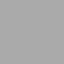

In [5]:
# val = /
mdata = pd.concat([data[:npoints],data[data['type']=='s1']])
model = GeologicalModel(boundary_points[0,:],boundary_points[1,:])
model.set_model_data(mdata)
fold_frame = model.create_and_add_fold_frame('s1',
                                             interpolatortype='FDI',
                                             nelements=10000,buffer=0.5,
                                             solver='pyamg',
                                            damp=True
                                            )
stratigraphy = model.create_and_add_folded_foliation('s0',
                                               fold_frame['feature'],
                                                nelements=10000,
                                               fold_axis=[-6.51626577e-06, -5.00013645e-01, -8.66017526e-01],
#                                                    limb_wl=1
                                                     buffer=0.5
                                                    )
viewer = LavaVuModelViewer(model,background="white")
# viewer.add_scalar_field(model.bounding_box,(38,55,30),
#                       'box',
#                      paint_with=stratigraphy,
#                      cmap='prism')
viewer.add_isosurface(fold_frame['feature'][0],
                      colour='blue',
#                       isovalue=0.4,
                      alpha=0.5)
viewer.add_data(fold_frame['feature'][0])
viewer.add_isosurface(fold_frame['feature'][1],colour='green',alpha=0.5,isovalue=0)
# viewer.add_vector_field(fold_frame['feature'][0],locations=fold_frame['feature'][0].get_interpolator().support.barycentre())
viewer.add_data(fold_frame['feature'][1])

# viewer.add_data(stratigraphy['feature'])
viewer.add_isosurface(stratigraphy['feature'])
viewer.interactive()
# plt.plot(stratigraphy['foliation'],stratigraphy['limb_rotation'],'bo')
# x = np.linspace(fold_frame['feature'][0].min(),fold_frame['feature'][1].max(),100)
# plt.plot(x,stratigraphy['fold'].fold_limb_rotation(x),'r--')

In [6]:
stratigraphy['feature'].get_interpolator().fold.fold_limb_rotation.calculate_misfit()

array([-0.01284538, -0.01794072, -0.17235975,  0.13233737,  0.03820645,
        0.06624756,  0.05720222, -0.00081031, -0.00213225, -0.03591516,
       -0.10895243,  0.02940599,  0.04845288,  0.09415088,  0.02746431,
       -0.03883288,  0.12062873, -0.10130576, -0.1125312 , -0.01057779])

In [7]:
def normal(value,mu, sigma):
    prob = -np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(value-mu)**2/sigma**2
#     print(prob)
    return prob#-np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(value-mu)**2/sigma**2

def jefferyprior(sigma):
    if sigma <= 0:
        return -np.inf
    return np.log(sigma)

### Define the fixed parts of the model

In [8]:
from LoopStructural.modelling.fold import fourier_series
model = GeologicalModel(boundary_points[0,:],boundary_points[1,:])
model.set_model_data(mdata)
fold_frame = model.create_and_add_fold_frame('s1',
                                             interpolatortype='FDI',
                                             nelements=10000,buffer=0.5,
                                             solver='pyamg',
                                            damp=True
                                            )

### Define log_likelihood


In [55]:

def log_likelihood(theta):
    # unpack parameters
    wl, c0, c1, c2 = theta
    sigma = 0.1
    fold_limb_function = lambda x: np.rad2deg(
                np.arctan(
                    fourier_series(x, c0, c1, c2, wl)))
    
    strati = model.create_and_add_folded_foliation('s0',
                                               fold_frame['feature'],
                                                nelements=10000,
                                               fold_axis=[-6.51626577e-06, -5.00013645e-01, -8.66017526e-01],
#                                                    limb_wl=1
                                                     buffer=0.5,
                                                   limb_function=fold_limb_function,
                                                   solver = 'fake'
                                            )
    misfit = strati['fold'].fold_limb_rotation.calculate_misfit()
    
    log_like = -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (0 - misfit) ** 2 / sigma ** 2)

    if ~np.isfinite(log_like):
        return -np.inf
    
    return log_like

In [60]:
def log_prior(theta):
    wl, c0, c1, c2 = theta
#     lp = jefferyprior(sigma)
    lp= normal(c0,0,1)
    lp+= normal(c1,0,1)
    lp+= normal(c2,0,1)
    lp+= normal(wl,10,3)
    return lp

In [61]:
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta)
    return lp + log_likelihood(theta)

In [62]:
import emcee
ndim = 4
start = np.zeros(ndim)#np.array([600,0,0,0])
scale = np.ones(ndim)
# scale[4]= 0.1
scale[0]=10
pos = start + scale * np.random.randn(10, ndim)
nwalkers, ndim = pos.shape

In [63]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(pos, 20, progress=True,tune=True)

100%|██████████| 20/20 [10:16<00:00, 30.82s/it]


State([[ -6.2460388    0.17854169   0.11814133  -0.23824068]
 [ 11.44523179   0.50336946   0.390955     0.8614864 ]
 [-11.80375622   0.95441379   0.91812679  -0.97456053]
 [ -1.06582616  -0.0407133    0.58367499   0.93614424]
 [  0.62585917   0.72564787  -0.30461405   0.84833454]
 [  2.30528196   0.3987977    0.5117337    0.35922209]
 [  1.83647962   0.02995874  -0.16278813   0.88809703]
 [-11.48147603   0.760791     0.92650476  -0.85826832]
 [  0.64019735   0.46486621   0.48836959   0.61421599]
 [ 11.00160868   0.64774092   0.41558769   0.80964837]], log_prob=[ -189345.62911196  -595224.06977739  -883575.31427869 -1108453.26341567
 -1155684.91047968  -765500.11432059  -726597.89957749  -853602.69779509
  -816749.06478062  -600492.01966945], blobs=None, random_state=('MT19937', array([1086752271, 3979191444, 1979679094,  151784406, 2144497802,
       1698876653,  117815407, 4008204343, 3579747320, 1759305473,
       1387560528, 3868003306, 3846336541, 2401559687, 1174442306,
       232

In [48]:
flat_samples = sampler.get_chain(discard=10, flat=True)

(array([ 4.,  9.,  8., 53., 17.,  0.,  3.,  4.,  1.,  1.]),
 array([-3.88819504e+02, -2.91714694e+02, -1.94609885e+02, -9.75050760e+01,
        -4.00266754e-01,  9.67045424e+01,  1.93809352e+02,  2.90914161e+02,
         3.88018970e+02,  4.85123779e+02,  5.82228588e+02]),
 <a list of 10 Patch objects>)

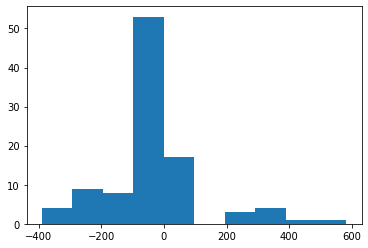

In [49]:
plt.hist(flat_samples[:,0])

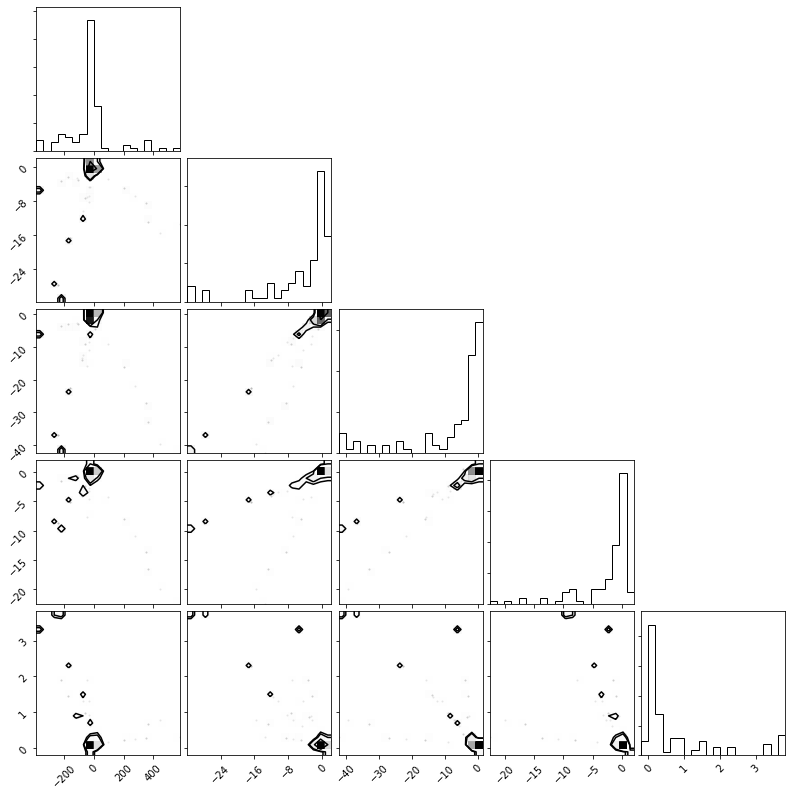

In [50]:
import corner
flat_samples.shape
fig = corner.corner(
    flat_samples
);

-4.168408084787533
96.23544622580255
5.384876197527227
-3.0578924395330054
-25.810396467624784
-1.3033432598604158
-157.85564898933728
9.381835375147693
18.36919527898988
-42.73966838974268


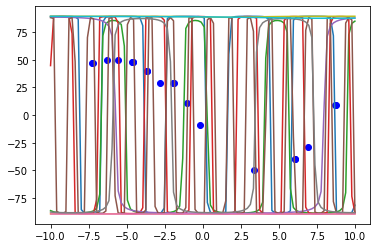

In [54]:
x = np.linspace(-10,10,100)
plt.plot(stratigraphy['fold'].fold_limb_rotation.fold_frame_coordinate,stratigraphy['fold'].fold_limb_rotation.rotation_angle,'bo')
for i in range(10):
    wl, c0, c1, c2, sigma = flat_samples[i,:]
    plt.plot(x,np.rad2deg(
                np.arctan(
                    fourier_series(x, c0, c1, c2, wl))))
    

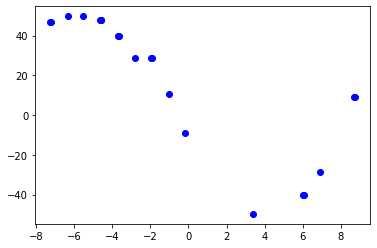

In [28]:
plt.plot(stratigraphy['fold'].fold_limb_rotation.fold_frame_coordinate,stratigraphy['fold'].fold_limb_rotation.rotation_angle,'bo')